In [1]:
# 绘制互相关系数对的震源距和密度统计图
import pygmt
import os
import pandas as pd
import numpy as np
import math
from obspy import geodetics
from tqdm import tqdm
from scipy.interpolate import interpn

In [2]:
def read_dtcc(ccfile,catalog=None):
    # 读取hypoDD dt.cc文件
    cc_list = []
    lines = open(ccfile,'r').readlines()
    for line in tqdm(lines):
        tmp = line.split()
        if tmp[0] == "#":
            evtid1,evtid2 = tmp[1],tmp[2]
            epi_dist,hyp_dist = None,None
            if evtid1 not in list(catalog) or evtid2 not in list(catalog):continue
            lat1,lon1,dep1 = catalog[evtid1]['latitude'],catalog[evtid1]['longitude'],catalog[evtid1]['depth']
            lat2,lon2,dep2 = catalog[evtid2]['latitude'],catalog[evtid2]['longitude'],catalog[evtid2]['depth']
            epi_dist,_,_ = geodetics.gps2dist_azimuth(lat1,lon1,lat2,lon2)
            epi_dist = epi_dist/1000
            hyp_dist = np.sqrt(epi_dist**2+(dep1-dep2)**2)
        else:
            station,dt,cc,pha = tmp
            cc_list.append([evtid1,evtid2,station,float(dt),float(cc),pha,epi_dist,hyp_dist])
    cc_list = pd.DataFrame(data=cc_list,columns=['evtid1','evtid2','station','dt','cc','phase','epi_dist','hyp_dist'])
    return cc_list

In [3]:
def density_scatter( x , y, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    max_density = data.max()
    print('max_density:',max_density)
    return x,y,z

In [4]:
# read the catalog
names = ['evtid','latitude','longitude','depth','X','Y','Z','ex','ey','ez',
         'year','month','day','hour','minute','second','magnitude',
         'nccp','nccs','nctp','ncts','rcc','rct','cid']
catalog = pd.read_csv('TGR_data/tomoDD09/RealDataInversion/Output_Files/tomoDD.reloc',sep='\s+',names=names)
catalog_dict = {}
for i in range(len(catalog)):
    line = catalog.iloc[i]
    evtid,lon,lat,dep = line.evtid,line.longitude,line.latitude,line.depth
    evtid = '%s'%(int(evtid))
    catalog_dict[evtid] = {'longitude':lon,'latitude':lat,'depth':dep}

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
C:\Users\luo\AppData\Local\Temp\ipykernel_34544\3149003443.py:5: SyntaxWarning: invalid escape sequence '\s'
  catalog = pd.read_csv('TGR_data/tomoDD09/RealDataInversion/Output_Files/tomoDD.reloc',sep='\s+',names=names)


In [5]:
bsfile = 'TGR_data/tomoDD09/ph2dt/new15_bs.cc'
bs = read_dtcc(bsfile,catalog_dict)

100%|██████████| 2833123/2833123 [05:29<00:00, 8594.29it/s] 


In [6]:
bs_p = bs[bs.phase=='P'].dropna()
bs_s = bs[bs.phase=='S'].dropna()

In [7]:
# 计算KDE密度
x,y = bs_p.hyp_dist.values,bs_p.cc.values
xp, yp, zp = density_scatter(x,y,bins=100)
zp = zp/max(zp)

x,y = bs_s.hyp_dist.values,bs_s.cc.values
xs, ys, zs = density_scatter(x,y,bins=100)
zs = zs/max(zs)

max_density: 2.1682840978185403
max_density: 3.327375467609418


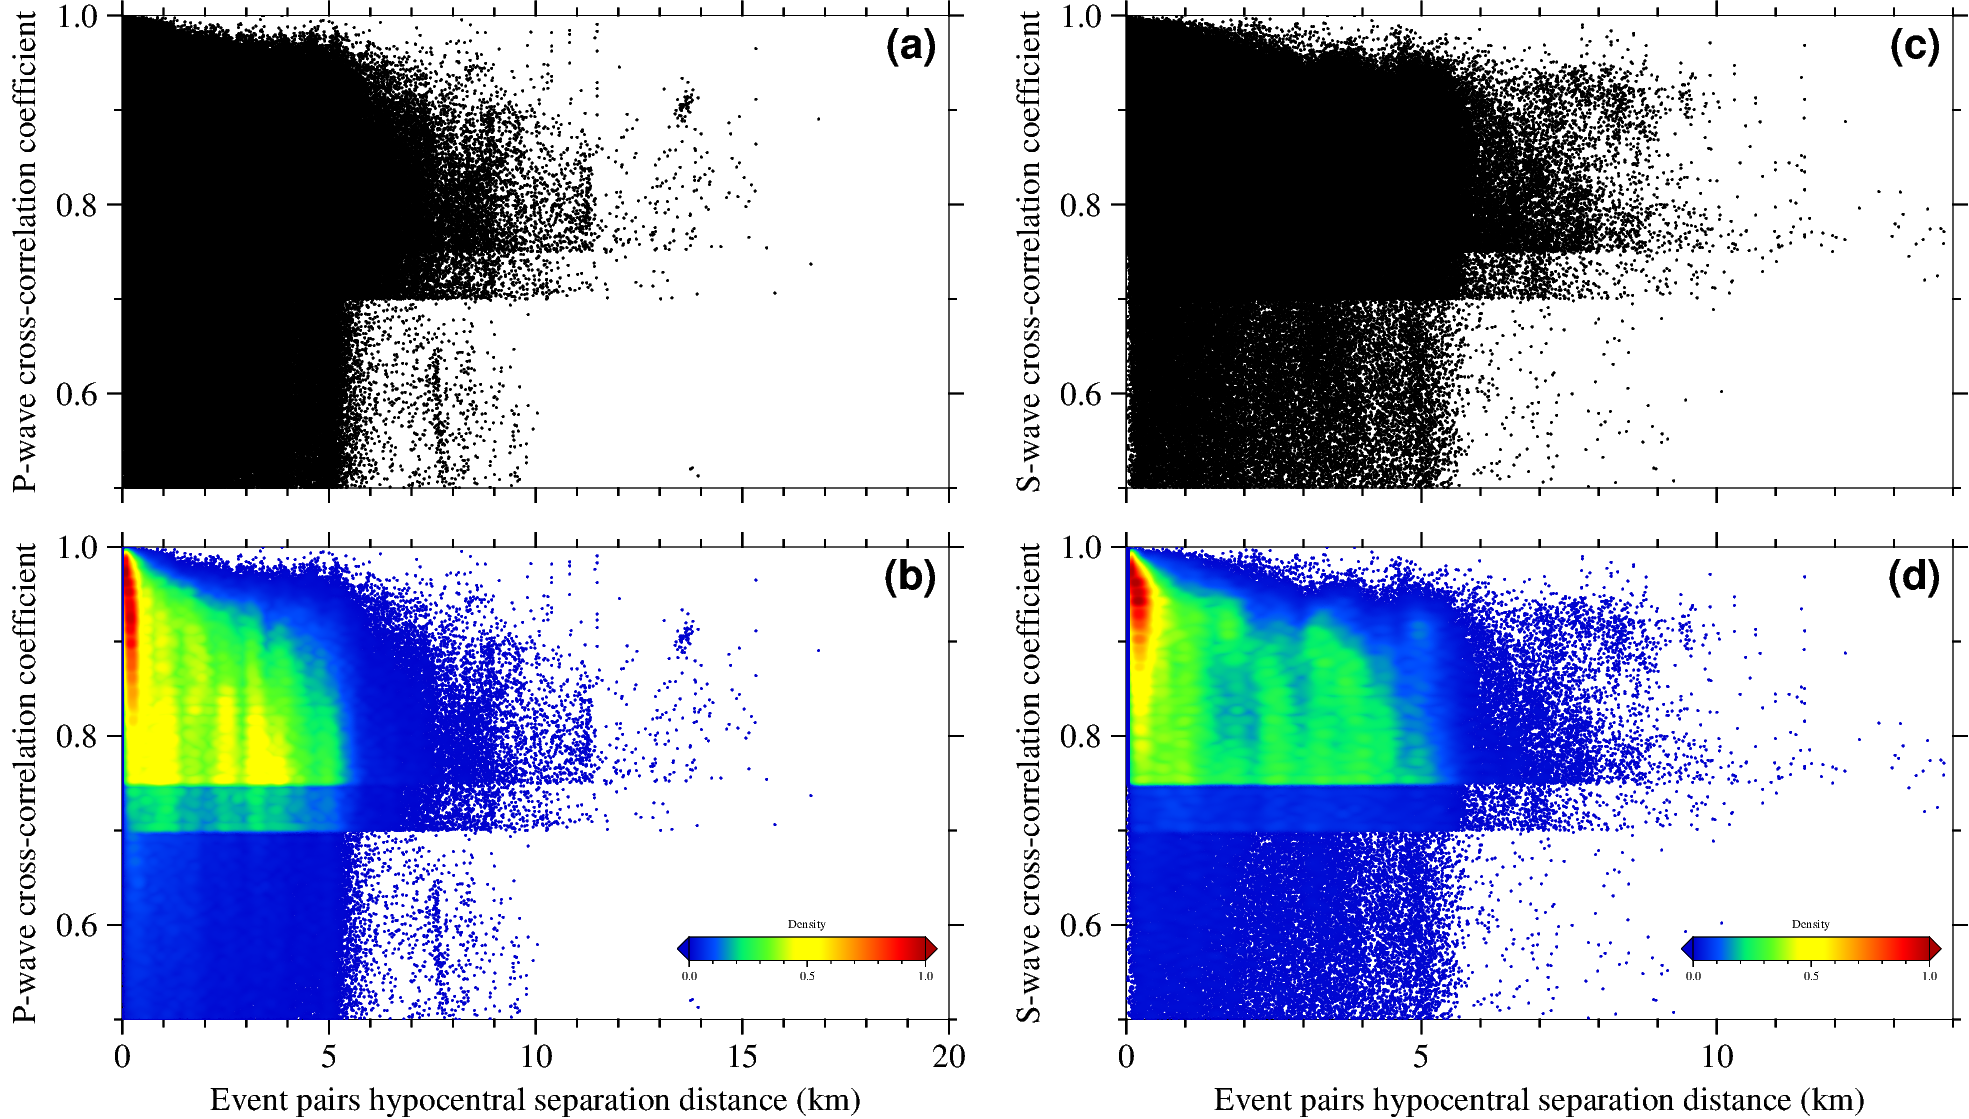

In [8]:
fig = pygmt.Figure()
pygmt.config(FONT='8p,4',MAP_FRAME_PEN='0.2p')
# P-wave
frame = ['xaf+lEvent pairs hypocentral separation distance (km)','yaf+lP-wave cross-correlation coefficient','Wsen']
fig.basemap(region=[0,20,0.5,1.0],projection='X7c/4c',frame=frame)
fig.plot(x=bs_p.hyp_dist,y=bs_p.cc,style='c0.02c',fill='black')
fig.text(position='cTR',text='(a)',font='10p,1',offset='j0.1c/0.1c')

fig.shift_origin(yshift='-4.5c')
frame = ['xaf+lEvent pairs hypocentral separation distance (km)','yaf+lP-wave cross-correlation coefficient','WSen']
fig.basemap(region=[0,20,0.5,1.0],projection='X7c/4c',frame=frame)
# 绘制密度
pygmt.makecpt(cmap='seis',series=[0,zp.max(),zp.max()/100],background=True,continuous=True,reverse=True)
fig.plot(x=xp,y=yp,style='c0.02c',fill=zp,cmap=True)
fig.colorbar(position='jBR+w2c/0.2c+o0.2c/0.5c+ml+h+e',frame=['xa0.5f0.1+lDensity'])
fig.text(position='cTR',text='(b)',font='10p,1',offset='j0.1c/0.1c')

# S-wave
fig.shift_origin(xshift='8.5c',yshift='4.5c')
frame = ['xaf+lEvent pairs hypocentral separation distance (km)','yaf+lS-wave cross-correlation coefficient','Wsen']
fig.basemap(region=[0,14,0.5,1.0],projection='X7c/4c',frame=frame)
fig.plot(x=bs_s.hyp_dist,y=bs_s.cc,style='c0.02c',fill='black')
fig.text(position='cTR',text='(c)',font='10p,1',offset='j0.1c/0.1c')

fig.shift_origin(yshift='-4.5c')
frame = ['xaf+lEvent pairs hypocentral separation distance (km)','yaf+lS-wave cross-correlation coefficient','WSen']
fig.basemap(region=[0,14,0.5,1.0],projection='X7c/4c',frame=frame)
# 绘制密度
pygmt.makecpt(cmap='seis',series=[0,zs.max(),zs.max()/100],background=True,continuous=True,reverse=True)
fig.plot(x=xs,y=ys,style='c0.02c',fill=zs,cmap=True)
fig.colorbar(position='jBR+w2c/0.2c+o0.2c/0.5c+ml+h+e',frame=['xa0.5f0.1+lDensity'])
fig.text(position='cTR',text='(d)',font='10p,1',offset='j0.1c/0.1c')
fig.show()
#fig.savefig('plotting_figures/Figure5_P1_sta.png',dpi=300)
#fig.savefig('plotting_figures/Figure5_P1_sta.pdf')

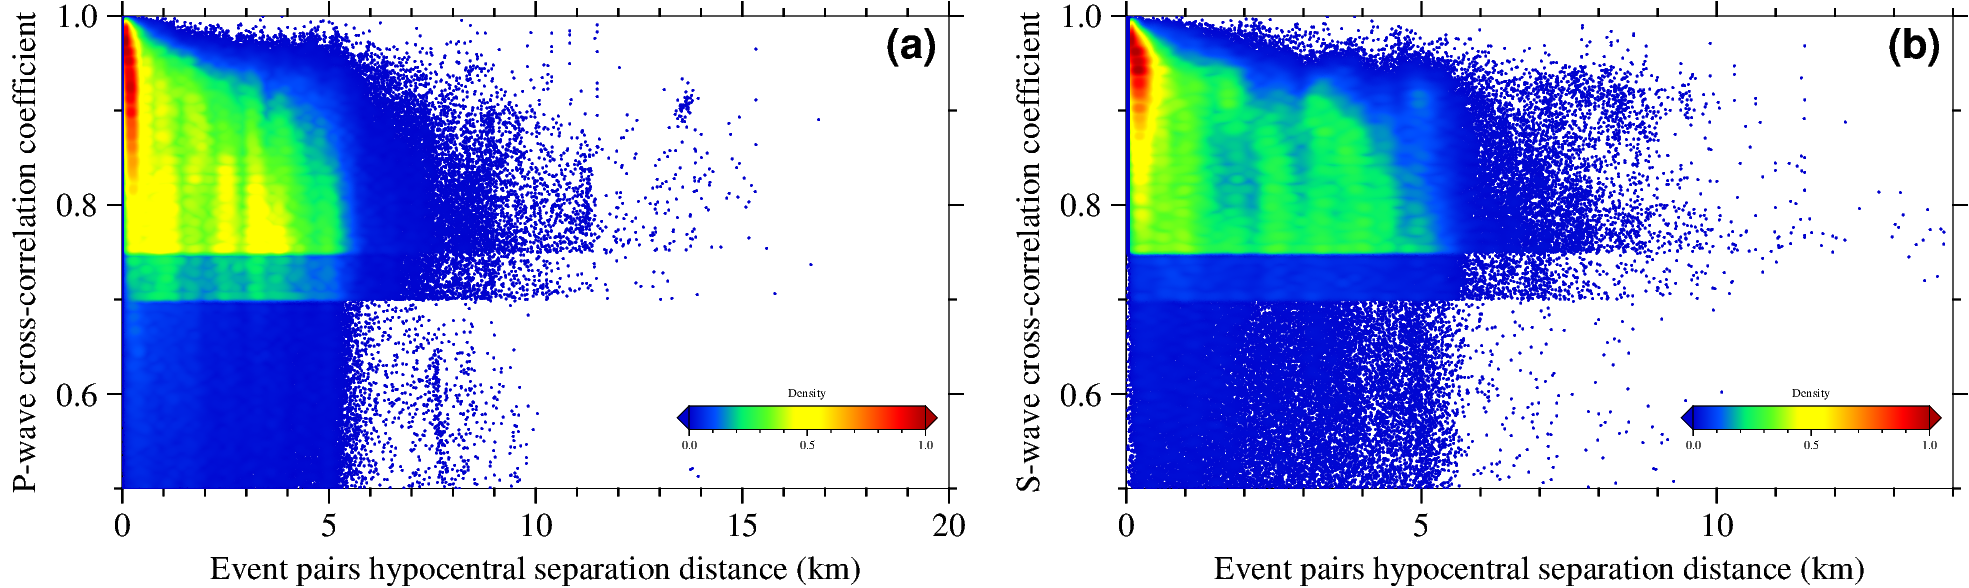

In [9]:
fig = pygmt.Figure()
pygmt.config(FONT='8p,4',MAP_FRAME_PEN='0.2p')
# P-wave
frame = ['xaf+lEvent pairs hypocentral separation distance (km)','yaf+lP-wave cross-correlation coefficient','WSen']
fig.basemap(region=[0,20,0.5,1.0],projection='X7c/4c',frame=frame)
pygmt.makecpt(cmap='seis',series=[0,zp.max(),zp.max()/100],background=True,continuous=True,reverse=True)
fig.plot(x=xp,y=yp,style='c0.02c',fill=zp,cmap=True)
fig.colorbar(position='jBR+w2c/0.2c+o0.2c/0.5c+ml+h+e',frame=['xa0.5f0.1+lDensity'])
fig.text(position='cTR',text='(a)',font='10p,1',offset='j0.1c/0.1c')

# S-wave
fig.shift_origin(xshift='8.5c')
frame = ['xaf+lEvent pairs hypocentral separation distance (km)','yaf+lS-wave cross-correlation coefficient','WSen']
fig.basemap(region=[0,14,0.5,1.0],projection='X7c/4c',frame=frame)
pygmt.makecpt(cmap='seis',series=[0,zs.max(),zs.max()/100],background=True,continuous=True,reverse=True)
fig.plot(x=xs,y=ys,style='c0.02c',fill=zs,cmap=True)
fig.colorbar(position='jBR+w2c/0.2c+o0.2c/0.5c+ml+h+e',frame=['xa0.5f0.1+lDensity'])
fig.text(position='cTR',text='(b)',font='10p,1',offset='j0.1c/0.1c')
fig.show()
fig.savefig('plotting_figures/Figure5_P1_sta.png',dpi=300)
fig.savefig('plotting_figures/Figure5_P1_sta.pdf')